# Computing Metacells - Projection Process

In this vignette we will demonstrate how to compute metacells starting with brand-new data, but heavily relying on a previously computed metacells atlas for similar data. This is very similar to the one-pass process, except that we have an "oracle" (the atlas) that helps us with the initial decisions (and with the type annotations). However, this oracle is *not* perfect, so this does not replace the iterative process, where we repeatedly revise our decisions; rather, it allows us to greatly reduce the number of iterations, by using with a much better starting point.

Here in the projection vignette we'll just show how to compute the first iteration to start this process. As times goes by, we hope to establish a library of atlases for various data sets, so that this would become the most common procedure for analyzing new data.

We will use the final results of the one-pass process as out atlas. To remove doubt, this atlas and the results presented here are **not** suitable for use in any serious analysis. This is an example of the process, nothing more.

## 1. Setup

We'll start with importing the python libraries we'll be using and setup some global configuration. Just importing takes a few seconds, mainly because Python's importing of C++ extensions with a large number of functions is inefficient.

In [1]:
%%time
import anndata as ad             # For reading/writing AnnData files
import matplotlib.pyplot as plt  # For plotting
import metacells as mc           # The Metacells package
import numpy as np               # For array/matrix operations
import pandas as pd              # For data frames
import os                        # For filesystem operations
import seaborn as sb             # For plotting
import scipy.sparse as sp        # For sparse matrices
import shutil                    # for filesystem operations
from math import hypot           # For plotting
from typing import *             # For type annotations

CPU times: user 6.8 s, sys: 10.4 s, total: 17.2 s
Wall time: 5.52 s


Then, configure the packages we use. Feel free to tweak as necessary.

In [2]:
%%time

# Use SVG for scalable low-element-count diagrams.
%config InlineBackend.figure_formats = ["svg"]

# A matter of personal preference.
sb.set_style("white")

# Running operations on an inefficient layout can make code **much** slower.
# For example, summing the columns of a row-major matrix.
# By default this will just be a warning.
# We set it to be an error here to make sure the vignette does not lead you astray.
#
# Note that this only affects the Metacells package.
# Numpy will happily and silently take 100x longer for running such inefficient operations.
# At least, there's no way I can tell to create a warning or error for this;
# also, the implementation for "inefficient" operations could be *much* faster.
#
# The workaround in either case is to explicitly re-layout the 2D matrix before the operations.
# This turns out to be much faster, especially when the matrix can be reused.
# Note that numpy is also very slow when doing matrix re-layout,
# so the metacells package provides a function for doing it more efficiently.
#
# Sigh.
mc.ut.allow_inefficient_layout(False)

CPU times: user 5.07 ms, sys: 1.1 ms, total: 6.17 ms
Wall time: 5.98 ms


True

Even though the process here is truly "one-pass", realistically it should be followed by additional iterations. We'll therefore save files under `output/projection/preliminary` to drive the point home - in fact, we'll need `output/projection/corrected` as well below.

In [3]:
%%time
shutil.rmtree("../output/projection", ignore_errors=True)
shutil.rmtree("../mcview/projection", ignore_errors=True)
os.makedirs("../output/projection/preliminary", exist_ok=True)
os.makedirs("../output/projection/corrected", exist_ok=True)

CPU times: user 0 ns, sys: 1.6 ms, total: 1.6 ms
Wall time: 7.73 ms


## 2. Reading the data

Our input here is the "clean" data. That is, unlike in the one-pass and iterative process vignettes, here we assume we already excluded all the bad genes and cells. Naturally you will have to go through the steps described there to obtain the clean data, but there's no value in repeating them here in this vignette.

Note that the atlas isn't a great help in cleaning your data. The thresholds of the atlas do not apply to the new data set. The list of excluded genes might, but, the atlas by definition does not include its excluded genes. It is convenient to look at the documentation published with the atlas for the list of genes that were excluded and use them as the basis. It good practice to include this list in the atlas documentation - for that matter, it is good practice to *have* atlas documentation in the 1st place. But even so, this isn't automated.

In [4]:
%%time
cells = ad.read_h5ad("../blobs/blood_aging.clean.h5ad")
mc.ut.top_level(cells)
mc.ut.set_name(cells, "blood_aging.cells")
print(f"Cells: {cells.n_obs} cells, {cells.n_vars} genes")

Cells: 30583 cells, 33511 genes
CPU times: user 138 ms, sys: 287 ms, total: 424 ms
Wall time: 1.09 s


We also need to read our atlas. We'll just load the results of the one-pass process here, with the understanding that this is just an example. This means you have to run the one-pass vignette before you can run this one. Note that we only need to load the metacells data. We do not need the per-cell data to use an atlas, and typically it is not published as part of the atlas as it is very large and is not used in the atlas-based analysis.

In [5]:
%%time
atlas = ad.read_h5ad("../output/one-pass/final/hca_bm.metacells.h5ad")
mc.ut.top_level(atlas)
mc.ut.set_name(atlas, "hca_bm.atlas.metacells")
print(f"Atlas: {atlas.n_obs} metacells, {atlas.n_vars} genes")

Atlas: 3134 metacells, 27261 genes
CPU times: user 120 ms, sys: 545 ms, total: 665 ms
Wall time: 1.25 s


Note that the new data set should use the "same" genes names as the atlas. This isn't a problem if both data sets were sequenced using the same (or "compatible") technologies. Note that is acceptable to have some genes only in the atlas, or only in the new data set; what is important is that if the "same" gene appears in both, it has the same name.

Alas, while there definitely are common conventions for gene names, there are no strongs standards for gene names - some (important!) genes have multiple names used in different systems. That's true even for well-studied organisms such as mice and men. If you are working with less studied exotic organisms such as, say jellyfish or fungi, the situation is even worse. We expect that as atlases accumulate this will become less of a problem as "de-facto" standards will emerge. For now, you are on your own here. In this vignette we have the names already aligned.

## 3. Compute the metacells

### 3.1 Decisions

Even though we have the clean cells data, we can't compute metacells for it before making a few more decisions.

#### 3.1.1 Lateral genes

A crucial decision when running metacells is the list of genes are lateral,
that is, should **not** be used to group cells together.
The poster child for this are cell-cycle genes.
These genes are strong and any clustering algorithm will therefore prefer to group together cells in the same cell-cycle state,
at the expense of mixing up other (reasonably close) cell states,
which are what we are actually interested in.
Note that lateral genes are still used in deviant cell detection,
that is, each lateral gene should still have a consistent expression level in all the cells in each metacell.

Since we have an atlas computed for similar data, we can leverage the work that went into computing it by simply starting with the list used for creating this atlas. Here in the projection vignette we'll use it as-is. Realistically, there's no guarantee this list would be perfect for our new data, and in theory it may contain genes that we may wish to keep, so it is a good idea to review it, and refine it in following iterations. Still, this is much easier than the start-from-scratch procedure described in the iterative process vignette, and the number of follow-up iterations "should" be much lower.

In [6]:
%%time
atlas_lateral_gene_names = atlas.var_names[atlas.var["lateral_gene"]]
# This will mark as "lateral_gene" any genes that match the above, if they exist in the clean dataset.
mc.pl.mark_lateral_genes(cells, lateral_gene_names=atlas_lateral_gene_names)

lateral_gene_mask = mc.ut.get_v_numpy(cells, "lateral_gene")
lateral_gene_names = set(cells.var_names[lateral_gene_mask])
print(sorted([
    name for name in lateral_gene_names
    if not name.startswith("RPL") and not name.startswith("RPS")
]))
print(f"""and {len([
    name for name in lateral_gene_names if name.startswith("RPL") or name.startswith("RPS")
])} RP[LS].* genes""")

set blood_aging.cells.var[lateral_gene]: 247 true (0.7371%) out of 33511 bools


['ACSM3', 'ANP32B', 'APOE', 'AURKA', 'B2M', 'BIRC5', 'BTG2', 'CALM1', 'CD63', 'CD69', 'CDK4', 'CENPF', 'CENPU', 'CENPW', 'CKS1B', 'CKS2', 'COX4I1', 'CXCR4', 'DNAJB1', 'DONSON', 'DUSP1', 'DUT', 'EEF1A1', 'EEF1B2', 'EIF3E', 'EMP3', 'FKBP4', 'FOS', 'FOSB', 'FTH1', 'G0S2', 'GGH', 'GMNN', 'GPR183', 'H2AFZ', 'H3F3B', 'HBM', 'HIST1H1C', 'HIST1H2AC', 'HIST1H2BG', 'HIST1H4C', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRA', 'HLA-DRB1', 'HLA-E', 'HLA-F', 'HMGA1', 'HMGB1', 'HMGB2', 'HMGB3', 'HMGN2', 'HNRNPAB', 'HSP90AA1', 'HSP90AB1', 'HSPA1A', 'HSPA1B', 'HSPA6', 'HSPD1', 'HSPE1', 'HSPH1', 'ID2', 'IER2', 'IGHA1', 'IGHA2', 'IGHD', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHM', 'IGKC', 'IGKV1-12', 'IGKV1-39', 'IGKV1-5', 'IGKV3-15', 'IGKV4-1', 'IGLC2', 'IGLC3', 'IGLC6', 'IGLC7', 'IGLL1', 'IGLL5', 'IGLV2-34', 'JUN', 'JUNB', 'LEPROTL1', 'LGALS1', 'LINC01206', 'LTB', 'MCM3', 'MCM4', 'MCM7', 'MKI67', 'MT2A', 'MYL12A', 'MYL6', 'NASP', 'NFKBIA', 'NUSA

#### 3.1.2 Noisy genes

The same considerations apply to noisy genes. We'll just start with the list from the atlas. Here in the projection vignette we'll use it as-is. Realistically it may be revised in follow-up iterations as usual.

In [7]:
NOISY_GENE_NAMES = [
    "CCL3", "CCL4", "CCL5", "CXCL8", "DUSP1", "FOS", "G0S2", "HBB", "HIST1H4C", "IER2", "IGKC",
    "IGLC2", "JUN", "JUNB", "KLRB1", "MT2A", "RPS26", "RPS4Y1", "TRBC1", "TUBA1B", "TUBB"
]

In [8]:
%%time
atlas_noisy_gene_names = atlas.var_names[atlas.var["noisy_gene"]]
# This will mark as "noisy_gene" any genes that match the above, if they exist in the clean dataset.
mc.pl.mark_noisy_genes(cells, noisy_gene_names=atlas_noisy_gene_names)
noisy_gene_mask = mc.ut.get_v_numpy(cells, "noisy_gene")
print(list(cells.var_names[noisy_gene_mask]))

set blood_aging.cells.var[noisy_gene]: 21 true (0.06267%) out of 33511 bools


['JUN', 'G0S2', 'IGKC', 'CXCL8', 'DUSP1', 'HIST1H4C', 'TUBB', 'TRBC1', 'HBB', 'KLRB1', 'TUBA1B', 'RPS26', 'FOS', 'MT2A', 'CCL5', 'CCL3', 'CCL4', 'JUNB', 'IER2', 'RPS4Y1', 'IGLC2']
CPU times: user 7.9 ms, sys: 839 µs, total: 8.73 ms
Wall time: 8.39 ms


#### 3.1.3 Parallelization

Finally, we need to decide on how much parallelization to use.
This is a purely technical decision - it does not affect the results, just the performance.

The more parallel piles we use, the faster the computation will be
(up to the number of physical processors, but that is handled automatically for us).

However, having more parallel piles means using more memory.
If we run out of memory, we'll need to reduce the number of parallel piles.
You can track the memory usage by running `top` or `htop` during the computation.

We provide a guesstimator for the maximal number of parallel piles that will fit in memory.
This is by no means perfect, but it is a starting point.

In [9]:
%%time
# Either use the guesstimator:
max_parallel_piles = mc.pl.guess_max_parallel_piles(cells)
# Or, if running out of memory manually override:
# max_paralle_piles = ...
print(max_parallel_piles)
mc.pl.set_max_parallel_piles(max_parallel_piles)

162
CPU times: user 450 µs, sys: 694 µs, total: 1.14 ms
Wall time: 844 µs


### 3.2 Computation

We are ready to actually group the cells into metacells.

#### 3.2.1 Hyper-parameters

The metacells pipeline has a *lot* of hyper parameters you can tweak. The defaults were chosen such that scRNA-seq data, especially 10x data, should work "well" out of the box. You should read the documentation and have a good understanding of the effect of anny parameter you may want to tweak, keeping in mind the synergy between some of the parameters.

If we had to call out one hyper-parameter you *might* wish to tweak, it would be the `target_metacell_size`. This specifies the "ideal" number of cells in each metacell. The algorithm works hard to keep the actual metacell size close to this value - in particular, metacells larger than twice this size will be split, and metacells which are much smaller than this size will be merged, or dissolved (become outliers).

By default this value is set to `96`. Setting it to a smaller value will create more metacells, which may allow capturing more subtle differences between cell states (e.g. along a gradient); this, however, would come at the cost of making less robust estimations of each gene's expression level in each metacell. This *might* be a worthwhile tradeoff if your cells are of higher quality.

One technical "hyper-paramater" you *must* specify is the `random_seed`. A non-zero value will genenrate reproducible results. A zero value will generate non-reproducible results and will be *slightly* faster. We "strongly urge" you to use a non-zero as reproducible results are *much* easier to deal with.

#### 3.2.2 Assigning cells to metacells

This is the core of the method.
It can take a while.
The dataset used in this example is trivial - it contains ~50K cells.
This takes ~2 minutes to compute on our hefty (48 HT cores, 0.5TB RAM) server.

In [10]:
%%time
mc.pl.divide_and_conquer_pipeline(cells, random_seed=123456)

set blood_aging.cells.var[selected_gene]: * -> False
set blood_aging.cells.var[rare_gene]: 16 true (0.04775%) out of 33511 bools
set blood_aging.cells.var[rare_gene_module]: 33495 outliers (99.95%) and 16 grouped (0.04775%) out of 33511 int32 elements with 1 groups with mean size 16
set blood_aging.cells.obs[cells_rare_gene_module]: 30557 outliers (99.91%) and 26 grouped (0.08501%) out of 30583 int32 elements with 1 groups with mean size 26
set blood_aging.cells.obs[rare_cell]: 26 true (0.08501%) out of 30583 bools
set blood_aging.cells.var[selected_gene]: 3994 true (11.92%) out of 33511 bools
set blood_aging.cells.obs[metacell]: 30583 int32s
set blood_aging.cells.obs[dissolved]: 0 true (0%) out of 30583 bools
set blood_aging.cells.obs[metacell_level]: 30583 int32s


CPU times: user 32.3 s, sys: 14.7 s, total: 47.1 s
Wall time: 1min 46s


#### 3.2.3 Collecting the metacells

The above merely computed a metacell name and index for each cell ("Outliers" and negative for outlier cells). We still need to collect all the cells of each metacell, to create a new `AnnData` where each profile is a metacell. Note that in this new metacells data, we no longer have UMIs per gene; instead, for each gene, we have an estimate of the fraction of its UMIs out of the total UMIs. Since `AnnData` can only hold a single 2D dataset, the result must be a separate object (with each "observation" being a metacell), so we copy all the per-gene annotations from the cells dataset to the result.

In [11]:
%%time
metacells = \
    mc.pl.collect_metacells(cells, name="blood_aging.preliminary.metacells", random_seed=123456)
print(f"Preliminary: {metacells.n_obs} metacells, {metacells.n_vars} genes")

set blood_aging.preliminary.metacells.obs[grouped]: 334 int64s
set blood_aging.preliminary.metacells.obs[total_umis]: 334 float64s
set blood_aging.preliminary.metacells.layers[total_umis]: ndarray 334 X 33511 float32s
set blood_aging.preliminary.metacells.obs[__zeros_downsample_umis]: 334 int64s
set blood_aging.preliminary.metacells.layers[zeros]: ndarray 334 X 33511 int32s
set blood_aging.cells.obs[metacell_name]: 30583 <U8s
set blood_aging.preliminary.metacells.var[gnames]: 33511 objects
set blood_aging.preliminary.metacells.var[rare_gene]: 16 true (0.04775%) out of 33511 bools
set blood_aging.preliminary.metacells.var[rare_gene_module]: 33511 int32s
set blood_aging.preliminary.metacells.var[pre_high_total_gene]: 33511 int32s
set blood_aging.preliminary.metacells.var[high_total_gene]: 33511 int32s
set blood_aging.preliminary.metacells.var[pre_high_relative_variance_gene]: 33511 int32s
set blood_aging.preliminary.metacells.var[high_relative_variance_gene]: 33511 int32s
set blood_aging

Preliminary: 334 metacells, 33511 genes
CPU times: user 449 ms, sys: 1.05 s, total: 1.5 s
Wall time: 2.96 s


If the input data contains per-cell annotations of interest,
then here would be a good place to convey that data to the metacells object.
Our example data here doesn't contain any annotations of interest so we'll skip this part.

### 3.3 Computing for MCView

So we have our metacells data. This is pretty opaque as of itself.
`MCView` is our interactive tool for exploring the data, and for assigning type labels to the metacells.

However, in order to use `MCView`, we first need to compute all sort of quality control data for `MCView` to display.
This again may take a while (but much less then computing the metacells above).

In [12]:
%%time
mc.pl.compute_for_mcview(adata=cells, gdata=metacells, random_seed=123456)

set blood_aging.preliminary.metacells.uns[mcview_format]: 1.0
set blood_aging.preliminary.metacells.uns[outliers]: 19
set blood_aging.preliminary.metacells.var[marker_gene]: 3366 true (10.04%) out of 33511 bools
set blood_aging.preliminary.metacells.obsp[obs_balanced_ranks]: 3984 nonzero (3.571%) out of 111556 elements
set blood_aging.preliminary.metacells.obsp[obs_pruned_ranks]: 1333 nonzero (1.195%) out of 111556 elements
set blood_aging.preliminary.metacells.obsp[obs_outgoing_weights]: 1333 nonzero (1.195%) out of 111556 elements
set blood_aging.preliminary.metacells.obsp[umap_distances]: csr_matrix 334 X 334 float32s (111222 > 0, 99.7%)
set blood_aging.preliminary.metacells.obs[u]: 334 float32s
set blood_aging.preliminary.metacells.obs[v]: 334 float32s
set blood_aging.preliminary.metacells.obs[w]: 334 float32s
set blood_aging.preliminary.metacells.obsp[obs_balanced_ranks]: 3984 nonzero (3.571%) out of 111556 elements
set blood_aging.preliminary.metacells.obsp[obs_pruned_ranks]: 133

CPU times: user 19min 11s, sys: 40.7 s, total: 19min 51s
Wall time: 41.5 s


Here's a preview of the 2D UMAP view of the data (without any color annotations, as we do not have type annotations yet):

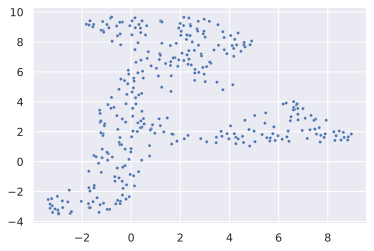

CPU times: user 1.18 s, sys: 5.06 s, total: 6.24 s
Wall time: 189 ms


In [13]:
%%time

# We'll reuse this below.
def plot_umap(*, type_annotation: Optional[str]) -> None:
    if type_annotation is not None:
        type_color_csv = pd.read_csv("../captured/type_colors.csv")
        color_of_type = pd.Series(
            list(type_color_csv["color"]) + ["magenta", "magenta"],
            index=list(type_color_csv["cell_type"]) + ["Outliers", "(Missing)"]
        )
        type_of_metacell = mc.ut.get_o_numpy(metacells, type_annotation)
        color_of_metacell = np.array(color_of_type[type_of_metacell])

    min_long_edge_size = 4
    umap_x = mc.ut.get_o_numpy(metacells, "x")
    umap_y = mc.ut.get_o_numpy(metacells, "y")
    umap_edges = sp.coo_matrix(mc.ut.get_oo_proper(metacells, "obs_outgoing_weights"))
    sb.set()
    if type_annotation is None:
        plot = sb.scatterplot(x=umap_x, y=umap_y, s=10)
    else:
        plot = sb.scatterplot(x=umap_x, y=umap_y, color=color_of_metacell, s=10)
    for (
        source_index, target_index, weight
    ) in zip(
        umap_edges.row, umap_edges.col, umap_edges.data
    ):
        source_x = umap_x[source_index]
        target_x = umap_x[target_index]
        source_y = umap_y[source_index]
        target_y = umap_y[target_index]
        if hypot(target_x - source_x, target_y - source_y) >= min_long_edge_size:
            plt.plot([source_x, target_x], [source_y, target_y],
                     linewidth=weight * 2, color='indigo')
    plt.show()
    
plot_umap(type_annotation=None)

# 4. Projection

Normally, now we would have now used `MCView` to manuall add type annotations to the metacells, review the gene lists and in general continue with the iterative process. However, we have an atlas with type annotations, which has much more data, and can be used to give us immediate automatic insights about our data, including initial type annotations. Again, this does not excuse us from performing additional iterations to review and refine the analysis, but it significantly reduces our effort.

## 4.1 Computing the projection

Computing the projection requires no decisions from us - that's the whole point. The one required option is whether we want to use the `reproducible` (slightly slower) implementation or we are OK with a non-reproducible (slightly faster) implementation. We strongly recommend using the reproducible implementation as that makes life much easier when managing the analysis process.

(Actually we tell a lie, there is one important decision to make, described below. For now we'll pretend there isn't.)

The return value is a sparse weights matrix - for each metacell of our data, it gives its "best" representation as a weighted average of a few atlas metacells.

In [14]:
%%time
weights = mc.pl.projection_pipeline(adata=atlas, qdata=metacells, reproducible=True)

set blood_aging.preliminary.metacells.uns[project_max_projection_fold_factor]: 3 (X 8)
set blood_aging.preliminary.metacells.uns[project_max_projection_noisy_fold_factor]: 2 (X 4)
set blood_aging.preliminary.metacells.uns[project_max_misfit_genes]: 3
set blood_aging.preliminary.metacells.var[atlas_gene]: 19489 true (58.16%) out of 33511 bools
set blood_aging.preliminary.metacells.var[atlas_lateral_gene]: 247 true (0.7371%) out of 33511 bools
set blood_aging.preliminary.metacells.var[atlas_noisy_gene]: 21 true (0.06267%) out of 33511 bools
set blood_aging.preliminary.metacells.var[atlas_marker_gene]: 3188 true (9.513%) out of 33511 bools
set blood_aging.preliminary.metacells.var[atlas_noisy_gene]: 21 true (0.06267%) out of 33511 bools
set blood_aging.preliminary.metacells.var[projected_noisy_gene]: 21 true (0.06267%) out of 33511 bools
set blood_aging.preliminary.metacells.obs[total_atlas_umis]: 334 float32s
set blood_aging.preliminary.metacells.layers[corrected_fraction]: csr_matrix 33

CPU times: user 34.5 s, sys: 25 s, total: 59.5 s
Wall time: 45.9 s


In addition to the weights, this also set various annotations in the data. One of these is the `projected_type`, which is "if you *forced* me to pick a type annotation for each new data metacell, what would it be?". Note this does *not* necessarily mean this is the "right" type of the new data metacell. You should definitely review this (e.g. using `MCView`). For example, the new data metacell may be a doublet. Sometimes the projection algorithm will detect this, and indicate it by providing a non-empty `projected_secondary_type` for the metacell. Sometimes, the new data metacell may be of a new cell type that does not exist in the atlas. The projection algorithm will try and detect this, and indicate it by setting the `similar` mask to `False` for that metacell. And, of course, the projection algorithm is fallible. So you should *not* blindly accept the results.

At any rate, here's the same UMAP as above, but this time together with the `projected_type` annotations:

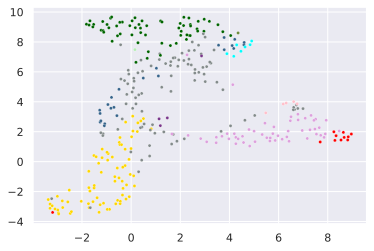

CPU times: user 1.15 s, sys: 5.24 s, total: 6.39 s
Wall time: 332 ms


In [15]:
%%time
plot_umap(type_annotation="projected_type")

### 4.2 Saving the data

We'll save the results on disk for future reference, and to allow them to be imported into `MCView`.

In [16]:
%%time
cells.write_h5ad("../output/projection/preliminary/blood_aging.cells.h5ad")

CPU times: user 434 ms, sys: 1.18 s, total: 1.62 s
Wall time: 5.08 s


In [17]:
%%time
metacells.write_h5ad("../output/projection/preliminary/blood_aging.metacells.h5ad")

CPU times: user 174 ms, sys: 170 ms, total: 343 ms
Wall time: 813 ms


This time, we also have the weights to consider. We'll wannt `MCView` to read them as well, so it will be able to provide us with nice features for dealing with the projection results.

In [18]:
%%time
mc.pl.write_projection_weights(
    "../output/projection/preliminary/blood_aging.atlas_weights.csv",
    adata=atlas,
    qdata=metacells,
    weights=weights
)

CPU times: user 64.2 ms, sys: 9.62 ms, total: 73.8 ms
Wall time: 66.1 ms


## 5. Importing into MCView

This vignette focuses on the metacells package, not `MCView`, which deserves a full vignette of its own. Still, here are some basics about how to use it.

### 5.1 Installing MCView

The `MCView` is written in `R` but is not a standard CRAN package.
To install it, you should type (**in `R`**):

```R
install.packages("remotes")
remotes::install_github("tanaylab/MCView")
```

### 5.2 Importing the data set

Since `MCView` is written in `R`, it isn't easy to run it inside a Python notebook.
Instead we've provided a small `R` script that will load the data we saved above,
and import it into an `MCView` application. Here is the code of the script for reference:

```R
library("MCView")

args <- commandArgs(trailingOnly=TRUE)

if (length(args) == 6) {
    prefix <- args[1]
    name <- args[2]
    title <- args[3]
    type <- args[4]
    atlas_prefix <- args[5]
    atlas_name <- args[6]
    import_dataset(
        sprintf("../mcview/%s", name),                           # The directory to create
        sprintf("%s-%s", prefix, gsub("/", "-", name)),          # The name of the dataset
        sprintf("../output/%s/%s.metacells.h5ad", name, prefix), # The metacells h5ad file
        metadata_fields = "all",                                 # Ask to import all the metadata
        title = title,                                           # A title for the GUI
        cell_type_field = type,                                  # The name of the type field
        cell_type_colors_file = "../captured/type_colors.csv",   # The type colors CSV file
        projection_weights_file = sprintf("../output/%s/%s.atlas_weights.csv", name, prefix),
        atlas_project = sprintf("../mcview/%s", atlas_name),
        atlas_dataset = sprintf("%s-%s", atlas_prefix, gsub("/", "-", atlas_name)),
    )

} else if (length(args) == 4) {
    prefix <- args[1]
    name <- args[2]
    title <- args[3]
    type <- args[4]
    import_dataset(
        sprintf("../mcview/%s", name),                           # The directory to create
        sprintf("%s-%s", prefix, gsub("/", "-", name)),          # The name of the dataset
        sprintf("../output/%s/%s.metacells.h5ad", name, prefix), # The metacells h5ad file
        metadata_fields = "all",                                 # Ask to import all the metadata
        title = title,                                           # A title for the GUI
        cell_type_field = type,                                  # The name of the type field
        cell_type_colors_file = "../captured/type_colors.csv"    # The type colors CSV file
    )

} else if (length(args) == 3) {
    prefix <- args[1]
    name <- args[2]
    title <- args[3]
    import_dataset(
        sprintf("../mcview/%s", name),                           # The directory to create
        sprintf("%s-%s", prefix, gsub("/", "-", name)),          # The name of the dataset
        sprintf("../output/%s/%s.metacells.h5ad", name, prefix), # The metacells h5ad file
        metadata_fields = "all",                                 # Ask to import all the metadata
        title = title                                            # A title for the GUI
    )

} else {
    stopifnot(FALSE)
}
```

We'll just run it as an external process using `Rscript`:

In [19]:
%%time
os.system(
    "Rscript ../scripts/import_dataset.r blood_aging projection/preliminary 'BA PRJ|PRE' "
    "projected_type hca_bm one-pass/final"
)

ℹ creating ../mcview/projection/preliminary
→ You can edit the app configuration at '../mcview/projection/preliminary/config/config.yaml'
ℹ Importing blood_aging-projection-preliminary
ℹ Reading '../output/projection/preliminary/blood_aging.metacells.h5ad'
ℹ Processing metacell matrix
ℹ Processing 2d projection
ℹ Using 2D projection from anndata object
ℹ Calculating top genes per metacell (marker genes)
ℹ Calculating metacell correlations of default marker genes
ℹ Processing inner-folds matrix
ℹ Calculating top inner-fold genes
→ Added the Inner-fold tab to the config file. To change the tab order or remove it - edit the tabs section at: '../mcview/projection/preliminary/config/config.yaml'
ℹ Processing inner-stdev matrix
ℹ Calculating top inner-stdev genes
→ Added the Stdev-fold tab to the config file. To change the tab order or remove it - edit the tabs section at: '../mcview/projection/preliminary/config/config.yaml'
ℹ Taking cell type annotations from projected_type field in the an

CPU times: user 6.86 ms, sys: 56.8 ms, total: 63.7 ms
Wall time: 47.6 s


0

### 5.3 Running MCView

The simplest way to run `MCView` is, in `R`, to type:
    
```R
library(MCView)
run_app("mcview/projection/preliminary") # The path we imported the dataset into
```

Since `MCView` is a [shiny](https://shiny.posit.co/) application, you have many other options, which are outside the scope of this vignette.

# 6. Technology-Corrected Projection

We'll not go over all the `MCView` features for dealing with projection (a topic worthy of a vignette of its own). We'll note, however, that there's a new `Projection QC` tab which shows quality controls of the projection. We'll take a look at "Projected correlation per metacell". This shows us the distribution (across metacells) of the correlation between the new data set metacell and the projected image of the metacell on the atlas (that is, the weighted average of some atlas metacells). This is computed only for the genes the projection algorithm thinks it actually managed to project "well", so we expect it to be high. In fact, we expect it to be **very** high. Specifically, when we see a median of ~0.87 in the QC tab, we worry. That's an R^2 of ~0.75, that is, ~25% of the variance of the genes in the new data set is not captured by the projection on the atlas (we zoomed to the range 0.8 - 1.0):

![Uncorrected Correlation](../images/preliminary.correlation.svg)

So why this poor result? Well, it turns out, the new data set we are projecting was collected using 10X v3, while the atlas was computed using 10X v2. In general, any scRNA-seq technology has different sensitivity for different mRNA molecules, and this is equivalent to applying some technology-dependent multiplicative factor to the number of UMIs of each gene. For this reason, our projection mechanism will optionally try to estimate a multiplicative correction factor for each (relevant) gene, such that this will (ideally) cancel out the difference between the technologies.

This is not the default as applying it to data which is not expected to need such corrections may overfit the new data on the atlas. This overfitting is mild; for example, nucleus-only scRNA-seq data gives very non-linear biases for some mRNA molecules when compared to whole-cell data, so using this correction will *not* force-fit the data sets together (that is, you will still get lower R^2 and a lot of not-`similar` metacells). Still, overfitting is overfitting, and should never be the default. Use with care, YMMV, etc.

At any rate, let's re-run the projection with this correction. We'll start by renaming the data to distinguish it from the previous run. Note we do not need to re-compute the metacells:

In [20]:
%%time
mc.ut.set_name(metacells, "blood_aging.corrected.metacells")
print(f"Corrected: {cells.n_obs} metacells, {cells.n_vars} genes")

Corrected: 30583 metacells, 33511 genes
CPU times: user 0 ns, sys: 429 µs, total: 429 µs
Wall time: 376 µs


And recompute all the projection annotations, this time with `project_correction`:

In [21]:
%%time
weights = mc.pl.projection_pipeline(adata=atlas, qdata=metacells, project_corrections=True, reproducible=True)

set blood_aging.corrected.metacells.uns[project_max_projection_fold_factor]: 3 (X 8)
set blood_aging.corrected.metacells.uns[project_max_projection_noisy_fold_factor]: 2 (X 4)
set blood_aging.corrected.metacells.uns[project_max_misfit_genes]: 3
set blood_aging.corrected.metacells.var[atlas_gene]: 19489 true (58.16%) out of 33511 bools
set blood_aging.corrected.metacells.var[atlas_lateral_gene]: 247 true (0.7371%) out of 33511 bools
set blood_aging.corrected.metacells.var[atlas_noisy_gene]: 21 true (0.06267%) out of 33511 bools
set blood_aging.corrected.metacells.var[atlas_marker_gene]: 3188 true (9.513%) out of 33511 bools
set blood_aging.corrected.metacells.var[atlas_noisy_gene]: 21 true (0.06267%) out of 33511 bools
set blood_aging.corrected.metacells.var[projected_noisy_gene]: 21 true (0.06267%) out of 33511 bools
set blood_aging.corrected.metacells.obs[total_atlas_umis]: 334 float32s
set blood_aging.corrected.metacells.layers[corrected_fraction]: csr_matrix 334 X 33511 float32s (38

CPU times: user 49.5 s, sys: 31.5 s, total: 1min 20s
Wall time: 58.4 s


Here's the UMAP with these (improved) type annotations:

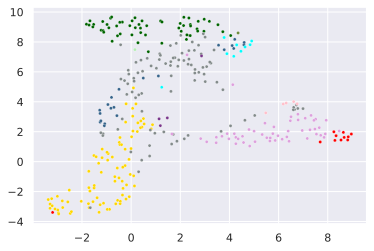

CPU times: user 1.17 s, sys: 5.12 s, total: 6.28 s
Wall time: 223 ms


In [22]:
%%time
plot_umap(type_annotation="projected_type")

And we'll save the data again for `MCView`:

In [ ]:
%%time
cells.write_h5ad("../output/projection/corrected/blood_aging.cells.h5ad")
metacells.write_h5ad("../output/projection/corrected/blood_aging.metacells.h5ad")
mc.pl.write_projection_weights(
    "../output/projection/corrected/blood_aging.atlas_weights.csv",
    adata=atlas,
    qdata=metacells,
    weights=weights
)
os.system(
    "Rscript ../scripts/import_dataset.r blood_aging projection/corrected 'BA PRJ|COR' "
    "projected_type hca_bm one-pass/final"
)

ℹ creating ../mcview/projection/corrected
→ You can edit the app configuration at '../mcview/projection/corrected/config/config.yaml'
ℹ Importing blood_aging-projection-corrected
ℹ Reading '../output/projection/corrected/blood_aging.metacells.h5ad'
ℹ Processing metacell matrix
ℹ Processing 2d projection
ℹ Using 2D projection from anndata object
ℹ Calculating top genes per metacell (marker genes)
ℹ Calculating metacell correlations of default marker genes
ℹ Processing inner-folds matrix
ℹ Calculating top inner-fold genes
→ Added the Inner-fold tab to the config file. To change the tab order or remove it - edit the tabs section at: '../mcview/projection/corrected/config/config.yaml'
ℹ Processing inner-stdev matrix
ℹ Calculating top inner-stdev genes
→ Added the Stdev-fold tab to the config file. To change the tab order or remove it - edit the tabs section at: '../mcview/projection/corrected/config/config.yaml'
ℹ Taking cell type annotations from projected_type field in the anndata object

If we look at the projected QC tab now, we see much better results (again we zoomed to the range 0.8 - 1.0):

![Corrected Correlation](../images/corrected.correlation.svg)

Now the median is ~0.95, which is an R^2 of ~0.90, that is, only ~10% of the variance of the (genes we *did* manage to fit) is not explained by the projection. Much better.

# 7. Follow-up iterations

In theory, that's it. We now have our final results, both as `h5ad` files and as an `MCView` application, to use as we see fit.

In practice, *not so fast*.

We **really** need to manually review the gene lists and the type annotations. Most likely, we'll at least modify the type annotations. We'll need to consider the `similar` and `secondary_projection_type` annotations, possibly marking some metacells as doublets. Note that the projection algorithm doesn't merely give you these high-level indicators. It allows you to look at the differential expression between the new data and the atlas, even for a specific metacell, to allow making the judgment calls about whether the new data metacell is "really" of some atlas type, or possibly requires a new cell type label which does not exist in the atlas.

Also, if we discover we need to modify the lateral or noisy genes lists, we'll have to recompute the new data metacells. If we do so, we may wish to project the improved metacells on the atlas for reference, but apply the previous iteration types, since they would be of higher quality.

In short, what we have done so far is effectively to merely skip to the N-th iteration of the iterative process, saving us a lot of effort, but we are by no means done.

To remove doubt, the results presented here are **not** suitable for use in any serious analysis. This is an example of the process, nothing more.